In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
folder_task = '/home/xingguang/Documents/ECE661/hw6/images'
imcat = cv2.imread(os.path.join(folder_task, 'cat.jpg'))
impigeon = cv2.imread(os.path.join(folder_task, 'pigeon.jpeg'))
imfox = cv2.imread(os.path.join(folder_task, 'fox.jpg'))

graycat = cv2.cvtColor(imcat, cv2.COLOR_BGR2GRAY)
graypigeon = cv2.cvtColor(impigeon, cv2.COLOR_BGR2GRAY)
grayfox = cv2.cvtColor(imfox, cv2.COLOR_BGR2GRAY)

In [ ]:
cv2.imwrite('cat.jpeg', imcat)

In [3]:
def Otsu(array):
    min_value = array.min().item()
    max_value = array.max().item()
    hist = cv2.calcHist([array],[0],None,[256],[min_value,max_value]).squeeze() / np.prod(array.shape)
    bins = np.linspace(min_value, max_value, 256)
    order1 = hist * bins

    omega_0 = np.cumsum(hist)
    omega_1 = 1 - omega_0
    cum_order = np.cumsum(order1)
    cum_order_r = cum_order[-1] - cum_order

    mu_0 = np.zeros_like(omega_0)
    start_id = 0
    for i in range(256):
        if omega_0[i] == 0:
            start_id+=1
        else:
            break
    mu_0[start_id:] = (1 / omega_0[start_id:]) * cum_order[start_id:]
    mu_1 = (1 / omega_1) * cum_order_r

    sigmaB = omega_0 * omega_1 * (mu_0 - mu_1) * (mu_0 - mu_1)
    idx = np.argmax(sigmaB) 
    K = bins[idx]
    # mask = np.zeros_like(img)
    # mask[np.where(img >= threshold)] = max_value
    return K

In [4]:
def iterOtsu(img, iter, l=False, reverse=False):
    array = img.ravel()
    for i in range(iter):
        k = Otsu(array)
        idx = np.where(array <= k) if l else np.where(array >= k)
        print(k, idx[0].shape)
        array = array[idx]

    mask = np.zeros_like(img, dtype=np.float32)
    if reverse:
        mask[np.where(img <= k)] = 1
    else:
        mask[np.where(img >= k)] = 1
    return mask, k

In [5]:
def BGRseg(img, iters, l=False, reverse=False):
    masks = []
    t = []
    for i in range(3):
        gray = img[:,:,i].squeeze()
        mask, threshold = iterOtsu(gray, iters[i], l, reverse)
        masks.append(mask)
        t.append(int(threshold))
    combined_mask = cv2.bitwise_and(masks[0], masks[1], masks[2])
    return combined_mask, t

In [6]:
def findContour(mask):
    expanded_mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    neighbor_mask = np.zeros_like(expanded_mask)
    # cv2.copyMakeBorder(src, top, bottom, left, right, borderType, value)
    tl = cv2.copyMakeBorder(mask, 0, 2, 0, 2, cv2.BORDER_REPLICATE)
    t = cv2.copyMakeBorder(mask, 0, 2, 1, 1, cv2.BORDER_REPLICATE)
    tr = cv2.copyMakeBorder(mask, 0, 2, 2, 0, cv2.BORDER_REPLICATE)
    l = cv2.copyMakeBorder(mask, 1, 1, 0, 2, cv2.BORDER_REPLICATE)
    r = cv2.copyMakeBorder(mask, 1, 1, 2, 0, cv2.BORDER_REPLICATE)
    bl = cv2.copyMakeBorder(mask, 2, 0, 0, 2, cv2.BORDER_REPLICATE)
    b = cv2.copyMakeBorder(mask, 2, 0, 1, 1, cv2.BORDER_REPLICATE)
    br = cv2.copyMakeBorder(mask, 2, 0, 2, 0, cv2.BORDER_REPLICATE)
    accu = tl + t + tr + l + r + bl + b + br
    neighbor_mask[np.where(accu < 8)] = 1
    contour = cv2.bitwise_and(neighbor_mask, expanded_mask)
    return contour[1:-1, 1:-1]

In [7]:
def largestComponent(mask, connectivity=8):
    new_img = np.zeros_like(mask, dtype=np.float32)
    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(mask.astype(np.uint8), connectivity)
    max_label, _ = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])
    new_img[np.where(output==max_label)] = 1
    return new_img

112.61176470588235 (422784,)
69.17647058823529 (377210,)
155.97254901960784 (416458,)
208.6235294117647 (399606,)
207.32549019607845 (398052,)
206.32941176470587 (396505,)


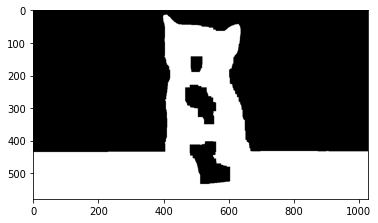

In [8]:
mask, t = BGRseg(imcat, iters=[2, 1, 3], l=True, reverse=False)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(mask,kernel,iterations = 7)
final_mask = cv2.erode(dilation,kernel,iterations = 6)

contour = findContour(final_mask)
plt.imshow(final_mask,cmap='gray')

# plt.imshow(contour,cmap='gray')

159.67450980392158 (62316,)
154.97254901960784 (79710,)
153.65098039215687 (86686,)


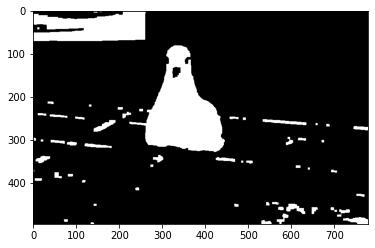

In [9]:
mask, t = BGRseg(impigeon, iters=[1, 1, 1], l=False, reverse=False)
kernel = np.ones((5,5),np.uint8)

opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
# erosion = cv2.erode(mask,kernel,iterations = 1)
dilation = cv2.dilate(opened,kernel,iterations = 1)
final_mask = cv2.erode(dilation,kernel,iterations = 1)
largest = largestComponent(final_mask)
contour = findContour(largest)
plt.imshow(final_mask,cmap='gray')
# plt.imshow(contour,cmap='gray')

43.83529411764706 (179245,)
91.60392156862744 (17847,)
108.14509803921568 (239936,)
93.57254901960783 (234036,)
138.82745098039214 (119814,)


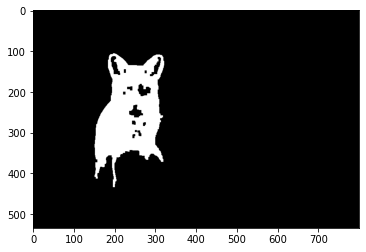

In [10]:
mask, t = BGRseg(imfox, iters=[2, 1, 2], l=False, reverse=False)
kernel = np.ones((5,5),np.uint8)

dilation = cv2.dilate(mask,kernel,iterations = 2)
final_mask = cv2.erode(dilation,kernel,iterations = 1)

# final_mask = cv2.erode(dilation,kernel,iterations = 1)
largest = largestComponent(final_mask)
contour = findContour(largest)
plt.imshow(largest,cmap='gray')
# plt.imshow(contour,cmap='gray')

In [11]:
def varmap(img, window_size):
    N = window_size
    b = int((N - 1) / 2)
    expand_im = cv2.copyMakeBorder(img, b, b, b, b, cv2.BORDER_REPLICATE)

    h, w = img.shape
    grids = np.zeros((h, w, N*N))
    for i in range(b, h+b):
        for j in range(b, w+b):
            grids[i-b, j-b] = expand_im[i-b:i+b+1, j-b:j+b+1].ravel()
    var_img = np.var(grids, axis=2, keepdims=False).astype(np.float32)
    return var_img

In [103]:
def contextseg(img, windows, iters, l=True, reverse=False):
    masks = []
    for i in range(len(iters)):
        var_img = varmap(img, windows[i])
        cv2.imwrite('var_'+str(windows[i])+'.jpg', var_img)
        mask, threshold = iterOtsu(var_img, iter=iters[i], l=l, reverse=reverse)
        masks.append(mask)
    combined_mask = cv2.bitwise_and(masks[0], masks[1], masks[2])
    return combined_mask

449.7254978553922 (582424,)
111.10361507640167 (534139,)
35.29123723647174 (483252,)
12.040503198960248 (463596,)
3.588138894473805 (451619,)
578.2223307291667 (575646,)
149.65342658547794 (520277,)
48.123675417432594 (470499,)
16.795993460860906 (455073,)
647.0029086243873 (567619,)
172.53162434895833 (505270,)
56.83385871438419 (460532,)
20.05895233154297 (448133,)


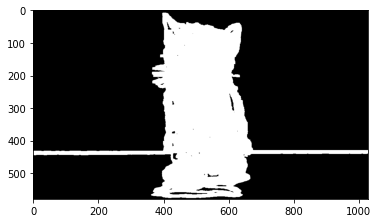

In [104]:
mask = contextseg(graycat, windows=[7, 11, 15], iters=[5, 4, 4], l=True)
plt.imshow(mask, cmap='gray')

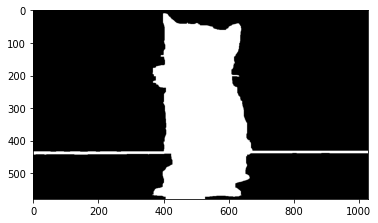

In [14]:
kernel = np.ones((5,5),np.uint8)

dilation = cv2.dilate(mask,kernel,iterations = 2)
final_mask = cv2.erode(dilation,kernel,iterations = 3)
contour = findContour(final_mask)
plt.imshow(final_mask,cmap='gray')
plt.imshow(contour,cmap='gray')

1400.5647173713235 (385153,)
181.08380342371325 (351049,)
61.77399920295266 (284190,)
23.72306889552696 (207730,)
1365.6511297487746 (383818,)
203.46875670189954 (335874,)
76.59761029411764 (248570,)
1257.5659639246323 (381993,)
221.81316779641543 (329192,)
88.72470092773438 (228386,)


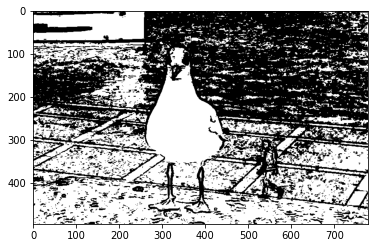

In [105]:
mask = contextseg(graypigeon, windows=[3, 5, 7], iters=[4, 3, 3], l=True, reverse=True)
plt.imshow(mask, cmap='gray')

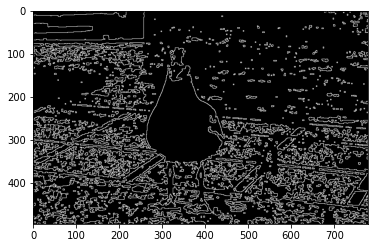

In [59]:
kernel = np.ones((3,3),np.uint8)

erosion = cv2.erode(mask,kernel,iterations = 1)
final_mask = cv2.dilate(erosion,kernel,iterations = 1)
contour = findContour(final_mask)
plt.imshow(largest,cmap='gray')
plt.imshow(contour,cmap='gray')

325.608340992647 (417874,)
91.92854434742647 (398594,)
28.103412583295036 (380960,)
8.374534277822457 (359741,)
402.268359375 (412681,)
119.89092227711396 (391252,)
37.608910654105394 (372517,)
478.07538686841724 (410027,)
146.26889864162487 (388048,)
43.072005178998495 (364737,)


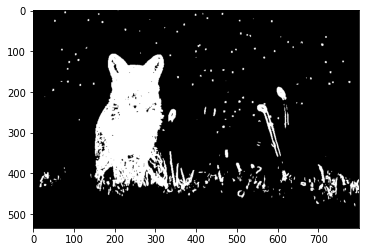

In [106]:
mask = contextseg(grayfox, windows=[3, 5, 7], iters=[4, 3, 3], l=True, reverse=False)
plt.imshow(mask, cmap='gray')

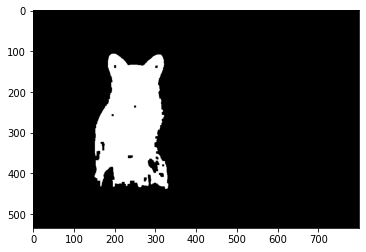

In [95]:
kernel = np.ones((3,3),np.uint8)

erosion = cv2.erode(mask,kernel,iterations = 1)
final_mask = cv2.dilate(erosion,kernel,iterations = 1)
largest = largestComponent(final_mask)
largest = cv2.dilate(largest,kernel,iterations = 2)
largest = cv2.erode(largest,kernel,iterations = 2)
contour = findContour(largest)
plt.imshow(largest, cmap='gray')

True

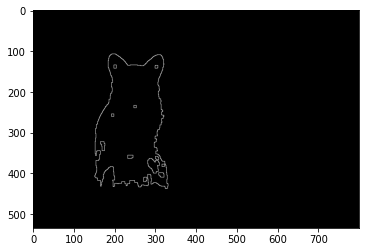

In [98]:
plt.imshow(contour,cmap='gray')
cv2.imwrite('contour.jpeg', contour*255)